#Reception of Films from Locations and Genres

##Table of Contents
* [Reception of Films from Locations and Genres](#Reception-of-Films-from-Locations-and-Genres)
    * [1. Overview](#1.-Overview)
	* [2. Data Acquisition & Management](#2.-Data-Acquisition-&-Management)
        * [2.1. Approach 1](#2.1.-Approach-1)
        * [2.2. Approach 2](#2.2.-Approach-2) 
    * [3. Analyses](#3.-Analyses)
        * [3.1. Summary Statistics of Data Set](#3.1.-Summary-Statistics-of-Data-Set)
        * [3.2. Principal Component Analysis](#3.2.-Principal-Component-Analysis)
        * [3.3. Train Test Splitting](#3.3.-Train-Test-Splitting)
        * [3.4. Logistic Regression](#3.4.-Logistic-Regression)
        * [3.5. K-Nearest Neighbours](#3.5.-K-Nearest-Neighbours)


In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random

In [2]:
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests

#1. Overview

In this project, we study the relationship between film reception and other factors like filming locations and genres. Data will be scraped from [IMDB](http://www.imdb.com). Principal Component Analysis(PCA) will be used for dimensionality reduction of our data set. Then, logistic regression and k-Nearest Neighbours(kNN) will be used for classification. The accuracy of both estimators will be compared. Visualisation of results will be done via graphical plots and Tableau.

#2. Data Acquisition & Management

We first scrape the data from IMDB which gives us information about each film title such as budget, country, critic ratings, duration, genre, gross earnings, language, location, name, opening weekend earnings, release dates, url, user ratings, user ratings count and year. Though we planned to work with a data set of 12,000 titles initially, a preliminary test run of PCA, particularly with around 18,000 features of locations and genres, indicated that it was infeasible. Instead, we reduce the size of our data to 10,000 title. To do so, we scraped IMDB for all film titles from 2009 to 2014. Titles without user ratings, film locations and genres are then removed from our data set. Subsequently, we pick 10,000 titles randomly from the remaining pool of titles.

First, we convert user ratings to a binary feature where "1" indicates that the film was well-received while "0" indicates otherwise. Initially, the threshold rating for determining if a film is well-received was not "5" nor is it a randomly chosen number. Instead, we looked at the spread of user ratings across our data. Films with ratings in the top 50% were assigned "1" while films in the bottom 50% were assigned "0". Though such conversion of user ratings might raise problems, the intention here is to have a balanced number for both sides; additionally, this technique can be applied to larger data sets where the threshold is determined by the data in hand. However, after some considerations, it was decided that "5" will be taken as the threshold since "5" is the boundary most people use when deliberating whether or not they like a film.

For locations, substantial data cleaning is required. This is largely due to film locations being user-contributed. Hence, we face problems like spelling mistakes, multiple entries of similar details or details with trivial differences that were irrelevant to our study. For example, some locations are specific to the street while others merely state the country. In cleaning up the feature "locations", we had considered two approaches which are elaborated below.

##2.1. Approach 1

We restrict "locations" to cities and countries. Using a list of cities, that we acquired online, and countries across the world, we split the entries of "locations" for each title by the commas into phrases. This is because most entries take the form - (specific location),(city),(country) - with various titles having anomalous and repeated entries. Phrases that appear in the list of cities and countries are kept while other location details are discarded. While this resulted in some problems, one particularly interesting issue was that many countries had names shared by cities. 

For example, China turned out to be the name of a city in Texas as well. As a result, if a film was filmed in China, Texas, it would be recorded as being filmed in the country China as well. However, given that these cities with similar names to countries are not especially known widely, we assume that such occurrences are rare anomalies. In addition, we chose to include countries so as to mitigate this problem since our hypothetical film will be recorded as being filmed in China and USA. As such, it is true that the film was filmed in USA but merely a rare anomaly that it is erroneously recorded to be filmed in China too.

While Approach 2 below was also considered, Approach 1 was taken instead due to the complexity of the latter.


##2.2. Approach 2

Here, we split the entries of "locations" by commas and treat each unique phrase as a distinct location. For example, suppose we have "Newbury Street, Boston, USA, Boston, USA". We split them into "Newbury Street", "Boston" and "USA". From a data set of around 18,000 titles, we end up with around 19,000 distinct locations as features. Then, we rely on PCA to reduce the number of features into principal components.

However, preliminary tests concluded that the computational demands of this approach was too immense. The number of components to be reduced to by PCA was intended to explain 90% of the variation in our features. While it was possible to find that number with our data set, the first few test runs simply took too long, prompting us to turn to the first approach instead.

In [3]:
new_df_input = pd.read_csv('df_boolean_temp2.csv',sep=',',encoding='utf-8')

In [4]:
new_df_input.drop('level_0', axis=1, inplace=True)
new_df_input.drop('Unnamed: 0', axis=1, inplace=True)
new_df_input.head()

,index,budget,contentRating,country,critic_ratings,duration,genre,gross,language,location_page,name,opening_weekend,release_dates,url,user_ratings,user_ratings_count,year,separated_places,separated_cities
0,0,"€1,500,000",NaN,Kazakhstan,NaN,110 min,[Drama],NaN,Russian,"[Minsk, Belarus , Almaty, Kazakhstan , St. Pet...",Ya ne vernus,NaN,[ 1 March 2014 (Russia) ],/title/tt2637844/,6.9,320,2014,"[minsk, belarus, almaty, kazakhstan, st. peter...","[minsk, belarus, almaty, kazakhstan, russia]"
1,3,NaN,NaN,USA,NaN,85 min,"[Horror, Mystery, Thriller]",NaN,English,"[Silt, Colorado, USA ]",Find Me,NaN,[ 1 September 2014 (USA) ],/title/tt3027188/,4.5,649,2014,"[silt, colorado, usa]","[silt, colorado, usa]"
2,4,NaN,NaN,Ireland,NaN,88 min,"[Comedy, Drama, Family]",NaN,English,"[Dublin, County Dublin, Ireland , County Wickl...",Gold,NaN,[ 10 October 2014 (Ireland) ],/title/tt3134422/,6.1,406,2014,"[dublin, county dublin, ireland, county wicklo...","[dublin, ireland, ireland]"
3,10,NaN,Not,USA,NaN,85 min,"[Action, Sci-Fi, Thriller]",NaN,English,"[Los Angeles, California, USA , Long Beach, Ca...",Mega Shark vs. Mecha Shark,NaN,[ 28 January 2014 (USA) ],/title/tt3152098/,2.6,"1,988",2014,"[los angeles, california, usa, long beach, cal...","[los angeles, california, usa, long beach, cal..."
4,11,NaN,NaN,Poland,NaN,117 min,"[Drama, Romance]",NaN,Polish,"[Ancona, Marche, Italy , Warsaw, Mazowieckie, ...",Obce cialo,NaN,[ 5 December 2014 (Poland) ],/title/tt3997248/,4.6,156,2014,"[ancona, marche, italy, warsaw, mazowieckie, p...","[ancona, marche, italy, warsaw, poland, moscow..."


In [5]:
#Get set of unique cities

def unique_entries(input_df, field):
    entries = set()
    for row in input_df[field]:
        for loc in row:
            entries.add(loc)
    return entries

#clean the column by removing brackets from the reads
def clean_column(input_df, field):
    cleanedrowlist = []
    for row in input_df[field]:
        cleanedrow =  row.replace('[', '')
        cleanedrow =  cleanedrow.replace(']', '')
        cleanedrow = cleanedrow.split(", ")
        cleanedrowlist.append(cleanedrow)
    input_df[field] = cleanedrowlist

Take 10,000 random samples.

In [6]:
random.seed(10)

SAMPLESIZE = 10000

newdf_boolean_sampled = new_df_input.copy()
clean_column(newdf_boolean_sampled, "separated_cities")
clean_column(newdf_boolean_sampled, "genre")

rows = random.sample(newdf_boolean_sampled.index, SAMPLESIZE)
newdf_boolean_sampled = newdf_boolean_sampled.ix[rows]

In [7]:
places3 = unique_entries(newdf_boolean_sampled, "separated_cities")
if "" in places3:
    places3.remove("")
if "..." in places3:
    places3.remove("...")
print len(places3) 

4802


In [8]:
genres3 = unique_entries(newdf_boolean_sampled, "genre")
genres3.remove("")
print len(genres3) 
print genres3

24
set([u'Sci-Fi', u'Crime', u'Romance', u'Animation', u'Music', u'Adult', u'Comedy', u'War', u'Horror', u'Western', u'News', u'Reality-TV', u'Thriller', u'Adventure', u'Mystery', u'Drama', u'Action', u'Musical', u'History', u'Family', u'Fantasy', u'Game-Show', u'Sport', u'Biography'])


In [9]:
Xsampleddf = pd.DataFrame()
#create a column for each city, and set to true if that row contains that city
for place in places3:
        Xsampleddf[place] = [place in location for location in newdf_boolean_sampled.separated_cities]
for genre in genres3:
        Xsampleddf[genre] = [genre in genre_entries for genre_entries in newdf_boolean_sampled.genre]

In [10]:
Xsampleddf = Xsampleddf.astype(int)

Getting user ratings and categorising them into well-received or not.

In [11]:
def get_median(input_df):
    rating_list = []
    for x in input_df["user_ratings"]:
        if isinstance(x, (np.ndarray, np.generic) ):
            rating_list.append(x)

    print np.mean(rating_list)
    ratingmedian = np.median(rating_list)
    print ratingmedian
    return ratingmedian

In [12]:
def get_ratingdf(inputdf):
    ratingsdf = pd.DataFrame()
    #ratingmedian = get_median(inputdf)
    ratingmedian = 5
    ratingslist = []
    for x in range(len(inputdf)):
        if inputdf["user_ratings"].iloc[x] >= ratingmedian:
            ratingslist.append(1)
        else:
            ratingslist.append(0)
    ratingsdf["reception"] = ratingslist
    return ratingsdf

In [13]:
ratingsdf_sampled = get_ratingdf(newdf_boolean_sampled)
ratingsdf_sampled.head()

,reception
0,0
1,1
2,1
3,0
4,1


Creating data frame for descriptive statistics.

In [14]:
newdf_boolean_sampled = newdf_boolean_sampled.reset_index()
newdf_boolean_sampled["user_ratings"].head()

0    4.1
1    5.8
2    5.9
3    4.1
4    6.6
Name: user_ratings, dtype: float64

In [15]:
statsdf = pd.DataFrame()
statsdf = pd.concat([newdf_boolean_sampled["user_ratings"], Xsampleddf], axis=1)
statsdf.head()

,user_ratings,trenton,bartoszyce,brindisi,bad grund,green river,ilulissat,chigasaki,collegeville,wilton manors,sichuan,nottingham,saylorsburg,uithoorn,brantford,roslyn,crete,kassel,tajikistan,zittau,san ignacio,sherman oaks,jaipur,paris,gig harbor,islip,potomac,colorno,geyserville,el campello,las palmas de gran canaria,pushkin,bagalkot,chennai,stanton,puente de ixtla,freudenstadt,wausau,aurora,bryn mawr,folsom,mary esther,bratislava,koprivnica,rapid city,truchas,georgia,jenkintown,roissy-en-france,cape may,...,deggendorf,kirkwood,harefield,warner springs,vence,whitby,heide,tarrytown,brechin,carcassonne,banff,montrose,baker,makati city,lloret de mar,charenton-le-pont,merthyr tydfil,scotch plains,oeiras,foster city,nuuk,abergele,westfield,bierset,arenys de mar,creuzburg,Sci-Fi,Crime,Romance,Animation,Music,Adult,Comedy,War,Horror,Western,News,Reality-TV,Thriller,Adventure,Mystery,Drama,Action,Musical,History,Family,Fantasy,Game-Show,Sport,Biography
0,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1,5.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0
3,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [16]:
np.mean(statsdf[statsdf.usa==1].user_ratings)

5.719843049327349

#3. Analyses

##3.1. Summary Statistics of Data Set

To give a better representations of the data set that we have, we will have some graphical plots of our data, like histograms across countries and genres. The large number of cities appearing in our data means that a histogram across all cities should be avoided. We can still study the frequency of the top few cities. Film reception can also be presented as a barplot.

Potentially, we might want to look at the relation between locations and genres. For example, what is the probability that a title was filmed in New York conditional on it being a drama. We might be able to write a function where you input parameters $X$ and $Y$, each representing a location, which may be a city, country or genre, and it returns $Probability(X|Y)$.

Other visualizations will be done using Tableau. For example, we can present the number of titles per city on a map in Tableau since we have city coordinates from the list of cities acquired.

(array([   25.,   117.,   323.,   676.,  1192.,  1955.,  2574.,  2083.,
          927.,   128.]),
 array([ 1.  ,  1.79,  2.58,  3.37,  4.16,  4.95,  5.74,  6.53,  7.32,
         8.11,  8.9 ]),
 <a list of 10 Patch objects>)

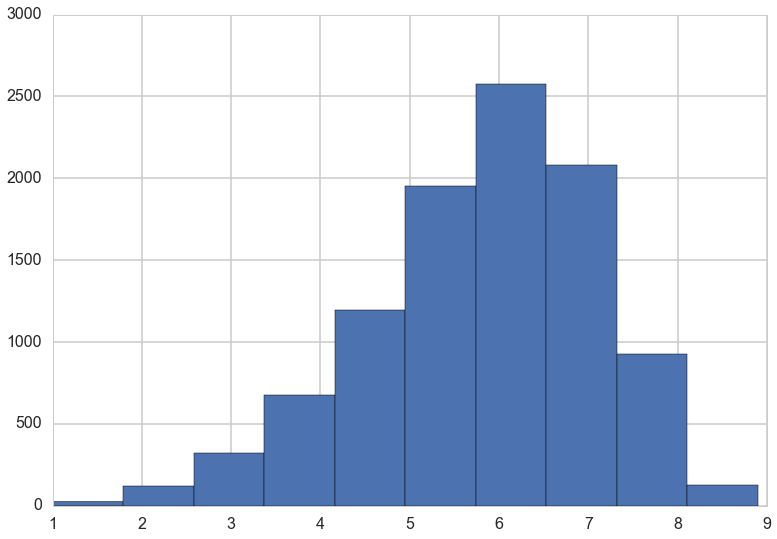

In [17]:
plt.hist(statsdf.user_ratings)

##3.2. Principal Component Analysis

We begin analysis by using PCA to reduce the number of dimensions features in the data. Our variation cutoff will be 5%. So if variation falls below 5% after a certain component, we will remove all remaining dimensions.

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1500)

new_X = pca.fit_transform(Xsampleddf)

In [19]:
pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()

0.950989475389


In [20]:
Xdf = pd.DataFrame()

for i in range(pca.explained_variance_ratio_.shape[0]):
    Xdf["pc%i" % (i+1)] = new_X[:,i]

In [21]:
Xdf.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,...,pc1451,pc1452,pc1453,pc1454,pc1455,pc1456,pc1457,pc1458,pc1459,pc1460,pc1461,pc1462,pc1463,pc1464,pc1465,pc1466,pc1467,pc1468,pc1469,pc1470,pc1471,pc1472,pc1473,pc1474,pc1475,pc1476,pc1477,pc1478,pc1479,pc1480,pc1481,pc1482,pc1483,pc1484,pc1485,pc1486,pc1487,pc1488,pc1489,pc1490,pc1491,pc1492,pc1493,pc1494,pc1495,pc1496,pc1497,pc1498,pc1499,pc1500
0,-0.066350,-0.670093,-0.050836,0.078633,-1.125600,-0.056040,-0.105434,0.190272,0.538619,-0.195652,-0.399023,-0.164460,-0.293033,-0.027973,0.122600,0.037682,0.003890,-0.031325,-0.011806,0.046461,-0.056476,-0.053256,0.008578,0.044745,-0.100227,0.071823,0.046617,0.066691,0.062903,0.000380,0.164204,-0.069500,-0.098806,0.166479,-0.150137,0.079788,-1.153106,-0.104587,-0.621643,-0.072449,0.047920,-0.040244,-0.065587,0.058357,0.000321,-0.000242,-0.021478,-0.027888,0.076853,0.009436,...,-0.000438,-0.002407,0.001025,0.002078,0.000568,-0.000128,0.000520,-0.002168,0.002026,-0.001497,-0.002197,-0.001142,0.000665,0.000840,-0.000200,0.001133,0.001909,-0.000977,0.000437,-0.001389,-0.001871,-0.000345,0.001306,0.000659,0.001392,-0.001358,-0.000818,0.001093,-0.000189,0.000809,-0.000589,0.000197,-0.000129,0.000094,0.000048,-0.001028,-0.000985,-0.000508,0.000316,-0.000454,0.000286,-0.000285,-0.000136,5.545358e-15,-1.071335e-15,8.011229e-17,2.192823e-15,-2.000105e-15,3.678057e-15,4.806914e-17
1,-0.560812,0.531123,0.382659,0.333944,-0.439023,0.241006,-0.316783,0.065685,0.135553,-0.021532,-0.771417,-0.326313,-0.164382,-0.026190,0.103695,0.084151,-0.096116,0.168581,0.021410,-0.009517,-0.020731,0.033012,-0.034160,0.054860,-0.053168,0.011908,-0.023070,0.023686,-0.010562,0.020057,-0.055836,0.003963,-0.053014,0.096105,-0.028106,-0.033452,0.033938,0.007513,-0.026669,0.034174,-0.029366,0.021898,0.011461,-0.025068,-0.001814,0.005328,0.018447,0.001233,0.018085,0.008192,...,0.006794,0.006914,0.005465,-0.000749,0.003412,0.007277,0.002803,0.003248,0.006883,-0.002268,0.000807,-0.000491,0.003035,0.006386,0.000034,-0.000559,0.003034,-0.003492,0.000237,-0.001926,-0.002465,0.000450,-0.001249,0.002407,0.000779,-0.004617,0.000620,-0.003264,-0.001933,0.001040,0.001819,0.001321,-0.001332,0.001044,-0.001357,0.001890,-0.001539,0.001206,-0.000218,-0.001807,-0.000571,-0.001234,-0.000651,-4.630789e-15,-8.194638e-15,1.200081e-15,2.935721e-15,3.506154e-15,1.522058e-15,-5.373756e-16
2,0.610763,-0.315403,-0.474722,-0.212557,0.035915,0.524099,-0.173022,-0.202003,-0.186362,-0.111612,0.462814,-0.012471,-0.039386,-0.038874,-0.399794,0.047593,-0.805383,0.360135,-0.076638,-0.156924,0.414043,0.139779,-0.321184,0.235991,0.442186,0.351778,0.342874,0.189957,0.033711,0.017275,0.737087,0.313009,-0.201215,0.233734,-0.029612,0.108084,0.090686,-0.022965,0.065336,0.012187,-0.055115,0.037796,0.054085,-0.055087,0.015385,0.008298,0.013550,0.009909,-0.006662,0.008863,...,0.009580,0.008613,-0.001274,-0.008282,0.000454,0.004485,-0.007032,-0.014146,-0.002670,0.008665,0.017603,-0.008668,0.005087,-0.000927,-0.005786,0.025804,0.009820,0.039011,0.012167,-0.080612,-0.005553,0.001007,0.007712,0.004880,-0.010619,0.026855,0.042320,0.013477,-0.019962,0.022043,0.009657,-0.023286,0.036905,0.011638,-0.012916,0.004692,-0.004997,-0.002481,0.020375,0.002992,-0.008840,0.002359,0.005339,6.705348e-15,8.061745e-15,4.665459e-15,-1.428342e-14,4.616225e-15,-2.493985e-14,-2.236853e-15
3,0.117680,0.499039,-0.666343,0.104795,0.429531,-0.598048,0.014088,-0.014096,0.173909,-0.139098,-0.152528,0.097668,0.120513,-0.009330,0.121165,-0.072110,-0.102072,-0.034262,0.052635,0.009866,0.080861,0.054988,0.001523,-0.011362,-0.001016,0.009547,-0.024669,-0.061805,-0.060235,0.011753,-0.009676,-0.018192,0.028999,-0.019510,0.033466,0.009968,-0.011181,0.009403,-0.021586,-0.018842,0.026755,-0.009931,-0.021578,0.037902,0.011662,0.012444,0.001497,-0.020722,0.0194

This gives us a data set with reduced dimension. Now, the features are the principal components.

##3.3. Train Test Splitting

Here, we split our data set into train and test sets. Our data set consists of 10,000 titles. We want training and testing data in the ratio 3:1. So, the size of each set will be 4,500 and 1,500, respectively.

In [22]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdf.values, ratingsdf_sampled['reception'].values, train_size=0.75, random_state=1)

##3.4. Baseline Accuracy

We calculate a baseline accuracy by assuming that all the predictions were well-received. This gives us a baseline of:

In [23]:
baseline  = sum(ytest)*1./len(ytest)
print 'Baseline Accuracy: %0.4f' % baseline

Baseline Accuracy: 0.7716


For our classifier to to worthwhile pursuing, the classifier's accuracy should be better than the baseline. This is what we will explore in the next few sections using logistic regression and KNN.

##3.5. Linear Regression

First, we perform a linear regression of user ratings on the dummy variables for each location and genre.

##3.4. Logistic Regression

We wish to study the effects of locations and genre on category. Since we have reduced locations and genres to principal components, we will perform a logistic regression of film reception on the principal components. We denote $ Y = $ Reception and $PC_c$ = Dummy Variable for principal component $c$.

Our regression equation will take the following form:

$$ P(Y_i=1) = F(\beta_0 + \delta_1 PC_{1i} + \delta_2 PC_{2i} + ... + \delta_C PC_{Ci})$$

where $\beta_0$ is the intercept parameter, $\delta_c$ are the slope parameters for the principal components and $F$ is the logistic function defined as:

$$ F(x) = \frac{e^x}{e^x + 1} $$

After estimating the coefficients, we apply the coefficient estimates on the test set. Then, we compare the accuracy of predicting $Y$ on both the training and test data.

In the code below, we first find the best paramater C for the logistic regression from the training set using 5-folds cross-validation.

In [24]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

First, we perform a regression using all the features of locations and genres as regressors to study the significance of each feature. To do so, we split statsdf into the same training and test data. We fit the model with our training data and test test on the test data.

In [25]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(Xsampleddf, ratingsdf_sampled['reception'].values, train_size=0.75, random_state=1)

In [26]:
clf=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clf, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(Xtrain2, ytrain2)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr',
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0),
 {'C': 0.1},
 0.77893333333333337,
 [mean: 0.76507, std: 0.00021, params: {'C': 0.0001},
  mean: 0.76507, std: 0.00021, params: {'C': 0.001},
  mean: 0.77893, std: 0.00646, params: {'C': 0.1},
  mean: 0.77680, std: 0.00652, params: {'C': 1},
  mean: 0.75720, std: 0.00695, params: {'C': 10},
  mean: 0.74413, std: 0.00556, params: {'C': 100}])

In the following code, we perform the logistic regression using the best parameter C, fit our training set and then test on the test data.

In [29]:
clflog=LogisticRegression(C=fitmodel.best_params_['C'])
clflog.fit(Xtrain2, ytrain2)
train_accuracy = clflog.score(Xtrain2,ytrain2)
test_accuracy=clflog.score(Xtest2,ytest2)
print "Accuracy on training data: %0.4f" % (train_accuracy)
print "Accuracy on test data:     %0.4f" % (test_accuracy)

Accuracy on training data: 0.7912
Accuracy on test data:     0.7892


##3.5. K-Nearest Neighbours

Next, we use the non-parametrised kNN classification with distance defined by the principal components. We train the data and use cross-validation to find the optimal K. Then, we look at the accuracy of prediction on the test data, comparing it with the training data.

This is the code for performing kNN classification:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf= KNeighborsClassifier(nbrs)
clf=clf.fit(Xtrain, ytrain)
accuracy = clf.score(Xtrain, ytrain)

This is the code to find the optimal k neighbours from training set:

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), param_grid={"n_neighbors": range(1,40,2)}, cv=5)
gs.fit(Xtrain, ytrain)
gs.best_params_

Then we apply to the test set and compare the accuracy with logistic regression.

In [ ]:
clfknn=KNeighborsClassifier(n_neighbors=gs.best_params_)
clfknn.fit(Xtrain, ytrain)
clfknn.score(Xtest, ytest)


In [ ]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfknn.fit(Xtrain, ytrain), alpha=0.3, psize=20)